In [1]:
import random
import numpy as np
import pandas as pd

#настройки, с которыми лучше
pd.set_option('display.max_rows', 45000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.max_colwidth', 5000)


In [2]:
# число жителей
N=200

# число заводов
k=50

# parameters
# salary
citizen_salary_parameter1=3
citizen_salary_parameter2=10

# параметры для отбора продукта
max_price=10000
min_qv=0

# разброс расходов
max_cost=100
min_cost=5

# разброс качества
max_qv=30
min_qv=2

# разброс капитала
cap_avarage=1000
cap_disp=300

# разброс инвестиций
capital_average=-100
capital_disp=50

# разброс изменений себестоимости
cost_average=0
cost_disp=5

# разброс изменений качества
qv_average=0
qv_disp=3

# число раундов в модели
R=10

In [3]:
# класс продукта      
class product:
    def __init__(self, id=-1, quality=-100, price=-10000):
        self.id=id
        self.quality=quality
        self.price=price
        
    # отображаем все параметры в виду dataframe
    def to_df(self):
        df=pd.DataFrame(data=[self.__dict__.values()], columns=self.__dict__.keys())
        return df

In [4]:
# класс потребителя
class citizen:
    def __init__(self, id=0):
        # id
        self.id=id
        # стартовый капитал
        self.money=self.set_salary()
    
    # задаём схему по которой человек будет получать зарплату
    # все схемы на основе генератора случайных чисел
    def set_salary(self):
        # "коммунизм", у всех одинаковое случайное число
        # return round(random.randint(10, 100),2)
        # "развитой социализм", нормальное распределение, у большиснтва средняя зарплата
        #return round(random.normalvariate((100-10)/2, 10),2)
        # "современное общество", есть длинный правый хвост
        return round(random.gammavariate(citizen_salary_parameter1, citizen_salary_parameter2),2)
        
    # функция потребления продуктов
    # берём то, что можем позволить по деньгам
    # берём самый качественный, который можем
    # при равном качестве тот, что дешевле
    def consume(self, products):
        # возвращать будем продукт
        fun_result=product(id=-1)
        available_product_lst=[]
        # цикл для фильтрации тех, что не карману
        for pr in products:
            if self.money>=pr.price:
                available_product_lst.append(pr)
        
        best_price=max_price
        best_qv=min_qv
        # цикл поиска лучшего качества
        for pr in available_product_lst:
            if pr.quality>=best_qv:
                best_qv=pr.quality
        
        product_qv_lst=[]
        # сбор всех продуктов лучшего качества
        for pr in available_product_lst:
            if pr.quality==best_qv:
                product_qv_lst.append(pr)
        
        # выбор из них тех, что дешевле
        for pr in product_qv_lst:
            if pr.price<=best_price:
                best_price=pr.price
        
        # вывод продукта с лучшими характеристиками
        for pr in product_qv_lst:
            if pr.price==best_price:
                fun_result=pr
                break
        
        return fun_result 
    
    # отображаем все параметры в виду dataframe
    def to_df(self):
        df=pd.DataFrame(data=[self.__dict__.values()], columns=self.__dict__.keys())
        return df
    

In [5]:
# класс фабрики        
class factory:
    def __init__(self, id=-1):
        # id
        self.id=id
        # предел качества продукта, меньше - можно
        self.max_quality=self.set_params()[0]
        # себестоимость
        self.cost=self.set_params()[1]
        # деньги у завода
        self.capital=self.set_params()[2]
        # продажи текущего периода
        self.pur=0
        # цена продажи текущего периода
        self.price=0
        self.capital_history=[]
        self.cost_history=[]
        self.quality_history=[]
        self.pur_history=[]
        self.price_history=[]
        self.history=pd.DataFrame()
        
    def set_params(self):
        max_quality=round(random.randint(min_qv, max_qv),0)
        selcost=round(random.randint(min_cost, max_cost),2)
        capital=round(random.normalvariate(cap_avarage, cap_disp),2)
        
        return max_quality, selcost, capital
        
    # функция проверки кредитоспособности
    def check(self):
        if self.capital<=0:
            return -1
        else:
            return 0

    #  функция производтсва
    def produce(self, product_id, price, quality):
        # если норм по капиталам, себестоимости и производственным мощностям, то вперёд
        if (price>self.cost) and (quality<=self.max_quality) and (self.check()==0):
            self.price=price
            return product(id=product_id, quality=quality, price=price)
        else:
            self.price=-10000
            return product(id=-1)
        
    # функкция сделки
    def trade(self):
        # расходы на производство считаем здесь, чтобы не заморачиваться пока остатками
        self.capital=self.capital-self.cost
        if self.check()==0:
            # поднимаем счётчики
            self.pur=self.pur+1
            self.capital=self.capital+self.price
        else:
            pass
        
    # храним историю продаж, запускаем в конце цикла
    def hist(self):#, period):
        self.capital_history.append(self.capital)
        self.cost_history.append(self.cost)
        self.quality_history.append(self.max_quality)
        self.pur_history.append(self.pur)
        self.price_history.append(self.price)
        
    def get_modern_params(self):
        capital_addon=round(random.normalvariate(capital_average, capital_disp),2)
        # костыль на случай отрицательных инвестиций
        if capital_addon>0:
            capital_addon=-10
        cost_addon=round(random.normalvariate(cost_average, cost_disp),2)
        qv_addon=round(random.normalvariate(qv_average, qv_disp),0)
        
        return qv_addon, cost_addon, capital_addon
    
    def modernise_proces(self,qv_addon, cost_addon, capital_addon):
        if (self.capital+capital_addon>0):
            if self.max_quality+qv_addon>0:
                self.max_quality=np.round(self.max_quality+qv_addon,0)
            if self.cost+cost_addon>0:
                self.cost=np.round(self.cost+cost_addon,2)
            self.capital=np.round(self.capital+capital_addon,2)
        else:
            pass
    
    # функция модернизации
    def modernise(self):
        # получили параметры модернизации
        qv_addon, cost_addon, capital_addon=self.get_modern_params()
        
        # если раунд не первый, то
        if len(self.pur_history)>1:
            # если сейчас продаж нет, а раньше были, то откатываемся
            if (self.pur_history[-1]==0)&(self.pur_history[-2]>0):
#                 print(self.id, ': 1')
                self.max_quality=self.quality_history[-2]
                self.cost=self.cost_history[-2]
            # иначе модернизируемся
            else: 
#                 print(self.id, ': 2')
                self.modernise_proces(qv_addon, cost_addon, capital_addon)
        # на первом раунде все модернизируются
        else: 
#             print(self.id, ': 3')
            self.modernise_proces(qv_addon, cost_addon, capital_addon)

    def to_null(self):
        # обнуляем счётчики текущего цикла
        self.price=0
        self.pur=0
    
    # отображаем все параметры в виду dataframe
    def to_df(self):
        df=pd.DataFrame(data=[self.__dict__.values()], columns=self.__dict__.keys())
        df=df.drop(columns=['history'])
        return df

In [6]:
# функции рынка, то есть встречи потребителей и продуктов
def global_produce(fact_lst):
    products=[]
    for f in fact_lst:
        if f.check()==0:
            product=f.produce(product_id=f.id, price=f.cost+1, quality=f.max_quality)
            products.append(product)
            
    return products

def global_consume(cit_lst, products):
    products_to_trade=[]
    for cit in cit_lst:
        product=cit.consume(products)
        products_to_trade.append(product)
        
    return products_to_trade

def global_trade(goods_to_trade, fact_lst):
    for good in goods_to_trade:
        if good.id>=0:
            fact_lst[good.id].trade()
            
def global_posttrade(fact_lst):    
    for fact in fact_lst:
        fact.hist()
        fact.to_null()
        fact.modernise()
        
    

def market_period(cit_lst, fact_lst, period):
    products_to_consume=global_produce(fact_lst)
    goods_to_trade=global_consume(cit_lst, products_to_consume)
    
    cit_df=pd.DataFrame()
    for i in range(len(goods_to_trade)):
        good=goods_to_trade[i].to_df()
        good['citizen_id']=i
        good['money']=cit_lst[i].money
        cit_df=pd.concat([cit_df, good])
        
    cit_df['period']=period
        
        
    global_trade(goods_to_trade, fact_lst)
    
    fact_df=pd.DataFrame()
    for fact in fact_lst:
        fact_df=pd.concat([fact_df, fact.to_df()])
        
    fact_df=fact_df[['id', 'max_quality', 'cost', 'capital', 'pur', 'price']]
    fact_df['period']=period
    
    global_posttrade(fact_lst)
    
    return cit_df, fact_df

def model(cit_lst, fact_lst, R):
    
    cit_df=pd.DataFrame()
    fact_df=pd.DataFrame()
    
    for r in range(R):
        cit_df_r, fact_df_r=market_period(cit_lst, fact_lst, r)
        cit_df=pd.concat([cit_df, cit_df_r])
        fact_df=pd.concat([fact_df, fact_df_r])
        
    return cit_df, fact_df

In [7]:
# базовые тесты
# проверяем, что продукт создаётся
pr_a_df=product(id=0).to_df()
pr_b_df=product(id=1, quality=50, price=99).to_df()

# проверяем, что житель создаётся
cit_a_df=citizen(id=0).to_df()

# проверяем распредление зарплат жителей
N=50
cit_lst=[]
cit_df=pd.DataFrame()
for i in range(N):
    cit=citizen(id=i)
    cit_lst.append(cit)
    cit_df=pd.concat([cit_df, cit.to_df()])
    
# проверяем функцию потребления
# житель для теста
cit_a=citizen(id=1)
cit_a.money=30
# выбор самого дешёго продукта равного качества
pr_a1=product(id=0, quality=10, price=20)
pr_a2=product(id=1, quality=10, price=30)
pr_a3=product(id=2, quality=10, price=40)
# выбор самого качественного продукта одной цены
pr_b1=product(id=3, quality=10, price=20)
pr_b2=product(id=4, quality=20, price=20)
pr_b3=product(id=5, quality=30, price=20)
# выбор оптимального доступного
pr_c1=product(id=6, quality=10, price=10)
pr_c2=product(id=7, quality=30, price=30)
pr_c3=product(id=8, quality=50, price=50)

# проверяем создаем завода
fact_a_df=factory(id=0).to_df()

# проверяем распредление параметров завода
n=10
fact_lst=[]
fact_df=pd.DataFrame()
for i in range(n):
    f=factory(id=i)
    fact_lst.append(f)
    fact_df=pd.concat([fact_df, f.to_df()])

# проверяем функцию производства
# завод для теста
fact_ap1=factory(id=1)
fact_ap1.max_quality=40
fact_ap1.cost=10
fact_ap1.capital=300
# проверка условия по себестоимости
pr1=fact_ap1.produce(202, price=20, quality=30)
pr2=fact_ap1.produce(203, price=10, quality=30)
pr3=fact_ap1.produce(203, price=9, quality=30)
# проверка условия по качеству
pr4=fact_ap1.produce(203, price=20, quality=10)
pr5=fact_ap1.produce(203, price=20, quality=30)
pr6=fact_ap1.produce(203, price=20, quality=50)

# проверяем функцию продажи
# продаём товар один раз
fact_tr1=factory(id=7)
fact_tr1.cost=10
fact_tr1.max_quality=15
fact_tr1.capital=300
fact_tr1.produce(product_id=18, price=20, quality=15)
fact_tr1.trade()

# пытаемся продать товар, когда у нас мало капитала
fact_tr2=factory(id=8)
fact_tr2.cost=10
fact_tr2.max_quality=15
fact_tr2.capital=5
fact_tr2.produce(product_id=18, price=20, quality=15)
fact_tr2.trade()

# тестируем функцию логирования
ht=factory(id=21)
ht.hist()
ht.capital=300
ht.hist()
ht.capital=350
ht.hist()

# массив заводов, покупки и логирование
n=5
fact_h_lst=[]
for i in range(n):
    f=factory(id=i)
    f.capital=300
    f.cost=10
    f.produce(product_id=i, price=11, quality=1)
    fact_h_lst.append(f)

for i in range(n):    
    for j in range(4):
        fact_h_lst[i].trade()
        fact_h_lst[i].hist()
        
# проверяем рандом параметров
t=factory(id=31)
nn=500
params_lst=[]
for i in range(nn):
    pl=t.get_modern_params()
    params_lst.append(pl)
params_df=pd.DataFrame(params_lst)
params_df.columns=['qv_addon', 'cost_addon', 'capital_addon']

In [8]:
pr_a_df #id=0 qv=-100 price=-10000

,id,quality,price
0,0,-100,-10000


In [9]:
pr_b_df #id=1 qv=50 price=99

,id,quality,price
0,1,50,99


In [10]:
cit_a_df #id=0 money=rand

,id,money
0,0,25.16


In [11]:
cit_df['money'].hist()

In [12]:
cit_a.consume([pr_a1, pr_a2, pr_a3]).to_df()  #id=0

,id,quality,price
0,0,10,20


In [13]:
cit_a.consume([pr_b1, pr_b2, pr_b3]).to_df() #id=5

,id,quality,price
0,5,30,20


In [14]:
cit_a.consume([pr_c1, pr_c2, pr_c3]).to_df() #id=7

,id,quality,price
0,7,30,30


In [15]:
fact_a_df #id=0, all rand or empty

,id,max_quality,cost,capital,pur,price,capital_history,cost_history,quality_history,pur_history,price_history
0,0,23,58,1076.99,0,0,[],[],[],[],[]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed1190be10>,
      dtype=object)

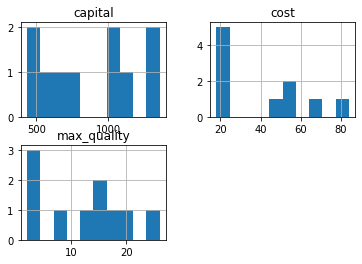

In [16]:
fact_df[['max_quality', 'cost', 'capital']].hist()

In [17]:
pr1.to_df() #id>0

,id,quality,price
0,202,30,20


In [18]:
pr2.to_df() #id<0

,id,quality,price
0,-1,-100,-10000


In [19]:
pr3.to_df() #id<0

,id,quality,price
0,-1,-100,-10000


In [20]:
pr4.to_df() #id>0

,id,quality,price
0,203,10,20


In [21]:
pr5.to_df() #id>0

,id,quality,price
0,203,30,20


In [22]:
pr6.to_df() #id<0

,id,quality,price
0,-1,-100,-10000


In [23]:
fact_tr1.to_df()  #capital=310 pur=1

,id,max_quality,cost,capital,pur,price,capital_history,cost_history,quality_history,pur_history,price_history
0,7,15,10,310,1,20,[],[],[],[],[]


In [24]:
fact_tr2.to_df()  #capital=-5 pur=0

,id,max_quality,cost,capital,pur,price,capital_history,cost_history,quality_history,pur_history,price_history
0,8,15,10,-5,0,20,[],[],[],[],[]


In [25]:
ht.to_df() # capital_hist=[rand, 300, 350]

,id,max_quality,cost,capital,pur,price,capital_history,cost_history,quality_history,pur_history,price_history
0,21,10,31,350,0,0,"[628.46, 300, 350]","[31, 31, 31]","[10, 10, 10]","[0, 0, 0]","[0, 0, 0]"


In [26]:
fact_h_lst[2].to_df()  #capital_history=[301, 302, 303, 304] pur=4

,id,max_quality,cost,capital,pur,price,capital_history,cost_history,quality_history,pur_history,price_history
0,2,2,10,304,4,11,"[301, 302, 303, 304]","[10, 10, 10, 10]","[2, 2, 2, 2]","[1, 2, 3, 4]","[11, 11, 11, 11]"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed117cfa58>,
      dtype=object)

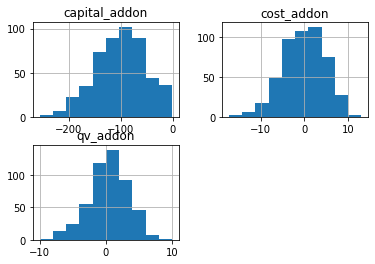

In [27]:
params_df.hist()

In [28]:
len(params_df[params_df['capital_addon']>0])/len(params_df)  # 0

0.0

In [29]:
# 1. продажи были - модернизировались, продажи пропали, далее как пойдёт
fact_tr31=factory(id=31)
fact_tr31.cost=10
fact_tr31.max_quality=15
fact_tr31.capital=300
fact_tr31.produce(product_id=31, price=11, quality=15)


fact_tr31.trade()
fact_tr31.hist()
fact_tr31.to_null()

fact_tr31.modernise()
fact_tr31.produce(product_id=31, price=fact_tr31.cost+1, quality=fact_tr31.max_quality)
# fact_tr31.trade()
fact_tr31.hist()
fact_tr31.to_null()

fact_tr31.modernise()
fact_tr31.produce(product_id=31, price=fact_tr31.cost+1, quality=fact_tr31.max_quality)
# fact_tr31.trade()
fact_tr31.hist()
fact_tr31.to_null()

# 2. продажи были - модернизировались, продажи остались, далее как пойдёт
fact_tr32=factory(id=32)
fact_tr32.cost=10
fact_tr32.max_quality=15
fact_tr32.capital=300
fact_tr32.produce(product_id=32, price=11, quality=15)


fact_tr32.trade()
fact_tr32.hist()
fact_tr32.to_null()

fact_tr32.modernise()
fact_tr32.produce(product_id=32, price=fact_tr32.cost+1, quality=fact_tr32.max_quality)
fact_tr32.trade()
fact_tr32.hist()
fact_tr32.to_null()

fact_tr32.modernise()
fact_tr32.produce(product_id=32, price=fact_tr32.cost+1, quality=fact_tr32.max_quality)
fact_tr32.trade()
fact_tr32.hist()
fact_tr32.to_null()


# 3. продажи не было - модернизировались, продажи появились, далее как пойдёт
fact_tr33=factory(id=33)
fact_tr33.cost=10
fact_tr33.max_quality=15
fact_tr33.capital=300
fact_tr33.produce(product_id=33, price=11, quality=15)


# fact_tr33.trade()
fact_tr33.hist()
fact_tr33.to_null()

fact_tr33.modernise()
fact_tr33.produce(product_id=33, price=fact_tr33.cost+1, quality=fact_tr33.max_quality)
fact_tr33.trade()
fact_tr33.hist()
fact_tr33.to_null()

fact_tr33.modernise()
fact_tr33.produce(product_id=33, price=fact_tr33.cost+1, quality=fact_tr33.max_quality)
fact_tr33.trade()
fact_tr33.hist()
fact_tr33.to_null()

# 4. продажи не было - модернизировались, продажи не появились, далее как пойдёт
fact_tr34=factory(id=34)
fact_tr34.cost=10
fact_tr34.max_quality=15
fact_tr34.capital=300
fact_tr34.produce(product_id=34, price=11, quality=15)


# fact_tr34.trade()
fact_tr34.hist()
fact_tr34.to_null()

fact_tr34.modernise()
fact_tr34.produce(product_id=34, price=fact_tr34.cost+1, quality=fact_tr34.max_quality)
# fact_tr34.trade()
fact_tr34.hist()
fact_tr34.to_null()

fact_tr34.modernise()
fact_tr34.produce(product_id=34, price=fact_tr34.cost+1, quality=fact_tr34.max_quality)
# fact_tr34.trade()
fact_tr34.hist()
fact_tr34.to_null()


df_fact_df_pull=pd.DataFrame()
df_fact_df_pull=pd.concat([fact_tr31.to_df(), fact_tr32.to_df(), fact_tr33.to_df(), fact_tr34.to_df()])


In [30]:
df_fact_df_pull

,id,max_quality,cost,capital,pur,price,capital_history,cost_history,quality_history,pur_history,price_history
0,31,15.0,10.00,248.01,0,0,"[301, 248.01, 248.01]","[10, 10.44, 10]","[15, 14.0, 15]","[1, 0, 0]","[11, 11.44, 11]"
0,32,10.0,10.26,102.38,0,0,"[301, 241.4, 102.38]","[10, 13.07, 10.26]","[15, 14.0, 10.0]","[1, 1, 1]","[11, 14.07, 11.26]"
0,33,8.0,5.42,164.24,0,0,"[300, 175.58, 164.24]","[10, 5.42, 5.42]","[15, 14.0, 8.0]","[0, 1, 1]","[11, 6.42, 6.42]"
0,34,11.0,0.74,223.37,0,0,"[300, 286.57, 223.37]","[10, 0.74, 0.74]","[15, 13.0, 11.0]","[0, 0, 0]","[11, 1.74, 1.74]"


In [31]:
# Большой тест всего функционала
# генерация жителей
N=10
cit_lst=[]
for i in range(N):
    cit=citizen(id=i)
    cit.money=10+10*i
    cit_lst.append(cit)
    
# генерация трёх заводов
fact_lst=[]
fact=factory(id=0)
fact.max_quality=10
fact.cost=10
fact_lst.append(fact)

fact=factory(id=1)
fact.max_quality=20
fact.cost=20
fact_lst.append(fact)

fact=factory(id=2)
fact.max_quality=50
fact.cost=50
fact_lst.append(fact)

In [42]:
cit_df=pd.DataFrame()
fact_df=pd.DataFrame()
cit_df, fact_df=model(cit_lst, fact_lst, 3)

In [43]:
cit_df[0:10]

,id,quality,price,citizen_id,money,period
0,0,16.0,5.48,0,10,0
0,0,16.0,5.48,1,20,0
0,1,40.0,25.48,2,30,0
0,2,56.0,37.14,3,40,0
0,2,56.0,37.14,4,50,0
0,2,56.0,37.14,5,60,0
0,2,56.0,37.14,6,70,0
0,2,56.0,37.14,7,80,0
0,2,56.0,37.14,8,90,0
0,2,56.0,37.14,9,100,0


In [44]:
fact_df

,id,max_quality,cost,capital,pur,price,period
0,0,16.0,4.48,516.99,2,5.48,0
0,1,40.0,24.48,47.42,1,25.48,0
0,2,56.0,36.14,130.56,7,37.14,0
0,0,21.0,0.40,474.82,2,1.40,1
0,1,40.0,24.48,49.42,2,25.48,1
0,2,58.0,45.23,127.33,6,46.23,1
0,0,24.0,1.26,292.26,2,2.26,2
0,1,40.0,24.48,52.42,3,25.48,2
0,2,61.0,53.41,111.84,5,54.41,2


## Начало работы

In [45]:
# число жителей
N=2000

# число заводов
k=50

# parameters
# salary
citizen_salary_parameter1=3
citizen_salary_parameter2=10

# параметры для отбора продукта
max_price=10000
min_qv=0

# разброс расходов
max_cost=100
min_cost=5

# разброс качества
max_qv=30
min_qv=2

# разброс капитала
cap_avarage=1000
cap_disp=300

# разброс инвестиций
capital_average=-100
capital_disp=50

# разброс изменений себестоимости
cost_average=0
cost_disp=5

# разброс изменений качества
qv_average=0
qv_disp=3

# число раундов в модели
R=25

In [48]:
# генерация жителей
cit_lst=[]
for i in range(N):
    cit=citizen(id=i)
    cit_lst.append(cit)
    
# генерация заводов
fact_lst=[]
for i in range(k):
    fact=factory(id=i)
    fact_lst.append(fact)

# старт модели
cit_df=pd.DataFrame()
fact_df=pd.DataFrame()
cit_df, fact_df=model(cit_lst, fact_lst, R)

In [51]:
len(fact_df)

1250

In [52]:
fact_df[-200:]

,id,max_quality,cost,capital,pur,price,period
0,0,20.0,98.64,19.49,0,99.64,21
0,1,8.0,30.24,6.30,0,31.24,21
0,2,15.0,49.29,70.90,0,50.29,21
0,3,9.0,105.21,15.33,0,106.21,21
0,4,45.0,13.24,4721.13,1660,14.24,21
0,5,2.0,76.98,2.94,0,77.98,21
0,6,23.0,36.99,24.76,0,37.99,21
0,7,31.0,69.62,4.92,0,70.62,21
0,8,16.0,46.12,14.07,0,47.12,21
0,9,19.0,72.36,39.22,0,73.36,21


In [65]:
pur_evolution=fact_df.pivot_table(index='period', columns='id', values='pur').fillna(0)
price_evolution=fact_df.pivot_table(index='period', columns='id', values='price').fillna(0)
quality_evolution=fact_df.pivot_table(index='period', columns='id', values='max_quality').fillna(0)
capital_evolution=fact_df.pivot_table(index='period', columns='id', values='capital').fillna(0)

In [66]:
pur_evolution

id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
period,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,260,1466,0,208,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,551,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,465,974,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,445,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,297,1251,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,263,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,171,0,0,0,1479,0,28,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1265,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,437,136,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,263,0,0,0,0,0,0,0,0,0,0,0,0,0,0,650,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,222,833,0,28,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1248,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,657,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1442,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,119,255,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1206,0,0,0,0,0,0,0,0,0,0,0,0,0,0,373,0,333,0,0,0,0,0,0,0,0,0,0,0,0,0


In [64]:
capital_evolution

id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
period,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,529.07,930.40,1238.27,517.05,755.78,1095.14,1022.00,944.39,476.66,984.65,595.92,961.55,1127.99,1426.16,1079.02,1407.67,1092.44,760.81,966.39,998.89,617.82,1574.05,803.82,1363.09,687.73,959.70,838.93,763.81,1117.99,965.96,499.38,828.97,752.15,522.43,907.08,1305.24,1231.72,2451.01,764.86,1285.22,529.30,720.13,733.33,579.70,464.76,477.25,1273.30,493.64,1344.21,1111.79
1,479.63,744.70,1124.49,492.86,1214.53,926.17,920.24,787.53,372.77,776.61,538.55,825.31,1004.45,1326.73,933.51,1334.30,927.15,712.53,931.97,859.40,576.62,1498.93,740.65,1307.35,660.54,811.99,726.84,681.45,994.61,955.96,320.21,730.01,639.23,459.52,897.08,1195.26,1615.71,3326.55,699.66,1259.88,436.49,663.01,613.04,490.73,280.98,370.04,1179.77,361.41,1214.69,1042.10
2,356.22,557.78,963.78,296.33,1530.45,815.38,893.51,648.98,278.48,677.21,423.19,710.30,922.12,1187.69,785.75,1268.62,887.64,633.56,817.58,745.25,540.44,1374.52,633.89,1151.65,574.34,616.06,638.71,671.45,857.71,876.73,179.15,670.03,559.58,459.52,844.45,1185.26,1747.71,4494.65,498.72,1259.88,310.83,561.82,548.12,360.23,186.04,222.56,1132.29,153.06,1032.76,963.84
3,187.11,445.77,823.05,290.71,1725.58,620.60,817.42,596.18,142.99,537.50,305.16,571.04,770.82,1129.16,663.81,1144.85,718.57,569.58,690.15,703.61,480.47,1195.90,519.65,1076.95,502.85,545.02,399.36,525.48,746.53,703.62,99.19,560.96,448.86,508.34,731.56,1055.87,1651.31,5865.69,394.60,1274.56,130.59,522.63,458.55,286.22,85.83,133.14,973.06,53.34,988.83,811.44
4,64.95,311.16,702.72,175.02,1668.08,579.51,738.93,396.12,14.07,537.33,254.65,441.21,749.06,1010.88,595.56,1044.60,556.87,448.43,527.16,1830.70,409.73,1013.88,469.36,951.17,383.03,386.35,291.50,370.56,593.23,693.29,99.19,550.96,326.21,433.35,690.80,997.96,2088.31,5920.29,299.24,1210.48,110.26,412.17,309.82,193.48,-8650.20,133.14,841.79,50.35,888.29,788.11
5,64.95,103.54,589.84,118.95,1931.08,461.51,678.61,357.73,14.07,427.48,130.49,417.79,684.07,930.79,514.77,874.02,377.01,434.70,408.44,2411.99,293.70,929.84,440.49,836.96,262.72,264.81,177.07,189.64,509.79,615.58,99.19,403.48,233.46,433.35,606.07,869.22,2182.10,6584.06,187.79,1238.48,11.04,327.26,212.38,171.80,-8650.20,133.14,707.08,50.35,757.11,659.62
6,19.49,103.54,577.33,43.15,1810.69,377.85,589.79,227.92,14.07,310.74,130.49,347.22,542.53,819.23,507.95,804.18,258.78,323.52,330.11,3642.04,170.84,799.38,317.17,662.36,181.33,107.52,177.07,100.62,389.21,580.61,5.39,294.76,123.62,298.29,533.50,721.29,2203.06,7125.39,90.13,1119.86,11.04,234.95,197.16,121.83,-8650.20,29.40,608.16,20.87,698.96,540.20
7,19.49,87.56,427.19,43.15,1810.69,369.27,562.56,148.49,14.07,228.11,4.77,167.42,469.66,773.81,436.56,744.19,128.16,177.45,230.70,4912.09,41.05,609.67,206.01,605.59,86.74,107.52,65.96,8.54,327.16,458.44,5.39,284.76,123.62,172.39,415.21,664.55,2182.32,7370.39,80.13,1119.86,11.04,116.87,3.68,72.30,-8650.20,29.40,414.48,20.87,619.62,472.41
8,19.49,87.56,344.22,43.15,1653.44,228.63,443.62,138.49,14.07,98.31,4.77,45.14,460.81,688.00,368.66,718.51,43.79,169.56,134.81,5999.51,41.05,536.67,69.88,541.14,64.88,52.97,65.96,8.54,193.03,364.13,5.39,94.51,123.62,172.39,715.89,561.19,2444.31,7295.96,80.13,1007.82,11.04,116.87,3.68,72.30,-8650.20,29.40,282.10,20.87,558.33,377.44
